# CUTOUTS

In [1]:
__author__ = 'Steve Pothier <steve.pothier@noirlab.edu>'
__version__ = '20231212' # yyyymmdd; 
__keywords__ = ['HowTo', 'astronomy', 'tutorial', 'client', 'astroget', 'NOIRLab', 'cutout', 'chip']

<a class="anchor" id="Table-of-contents"></a>
## Table of contents
* [Goals & Summary](#goals)
* [Imports and setup](#imports)
* [Install astroget](#install)
* [Discover Images](#discover)
* [Get a single cutout from an image](#cutout_single)
* [Get a batch of cutouts (blocking)](#batch_blocking)
* [Get a batch of cutouts (non-blocking)](#batch_non_blocking)

<a class="anchor" id="goals"></a>
## Goals & Summary 
This notebook demonstrates using the `astroget` package to get cutouts from the [NOIRLab Astro Data Archive](https://astroarchive.noirlab.edu/).

**This runs a _Prototype BETA Release_ of the cutout service.** 

<a class="anchor" id="imports"></a>
## Imports and Setup

In [2]:
from pprint import pformat as pf
from pathlib import Path
from importlib import reload
from collections import defaultdict
from datetime import datetime, date
import warnings
import time
import tarfile
import random

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import numpy as np
import pandas as pd
from IPython.display import Audio
from IPython.display import display, Markdown, Latex

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# Suppress astropy warnings such as:
# WARNING: The following header keyword is invalid or follows an unrecognized ...
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# %matplotlib inline
# requires installing ipympl
%matplotlib widget
plt.rcParams['font.size'] = 14

<a class="anchor" id="install"></a>
## Install ASTROGET
Install the most recent version of the `astroget`.
*NOTE: After installing the most recent version, please restart your kernel.*

In [3]:
%%time
# ! pip install astroget==0.0.4a4         # A specific version 
# ! pip install --upgrade astroget        # Latest released version
# ! pip install --pre --upgrade astroget  # Latest pre-released version

# Uncomment next line to load ASTROGET from local current version of software. 
# (intended for ASTROGET developers only.)
! pip install --pre --upgrade ../..

Processing /home/pothiers/sandbox/astroget
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for astroget: filename=astroget-0.0.4a8-py3-none-any.whl size=582693299 sha256=c7e882d1c0332b7cc8744a35284ed711a704be9f74eddf3f2ec589c01c7a3fb1
  Stored in directory: /tmp/pip-ephem-wheel-cache-yggsb8f0/wheels/db/f5/81/f8567d8b9183e27b58f39e09c64a7e76e7ddf682313fc7caf2
Successfully built astroget
  Attempting uninstall: astroget
    Found existing installation: astroget 0.0.4a8
    Uninstalling astroget-0.0.4a8:
      Successfully uninstalled astroget-0.0.4a8
CPU times: user 163 ms, sys: 37.2 ms, total: 201 ms
Wall time: 21.1 s


In [4]:
import astroget.client
from astroget.utils import tic,toc
reload(astroget.client)

<module 'astroget.client' from '/home/pothiers/sandbox/astroget/venv/lib/python3.10/site-packages/astroget/client.py'>

<a class="anchor" id="configure"></a>
## Configure ASTROGET

In [5]:
print(f'Run started: {str(datetime.now())}')
# Server used must support client.cutout() methods !!!

#server = 'https://astroarchive.noirlab.edu'     # Public server,HDUs>=408,118,252 Files>=18,731,991
#server = 'https://marsnat1-pat.csdc.noirlab.edu'# Test Server,  HDUs>=26,246,808  Files>=711,608
server = 'http://localhost:8060'                # Dev Server,    HDUs>=1,216

nbdir = Path('notebook-outfiles')
nbdir.mkdir(parents=False, exist_ok=True)
#print(f'Will write files to: {str(Path.cwd() / nbdir)}')

client = astroget.client.CsdcClient(url=server, show_curl=False)
client

Run started: 2024-02-19 06:08:56.380978


astroget_vers=0.0.4a8, api_vers=7.0, url=http://localhost:8060, verbose=False, show_curl=False, connect_timeout=3.05, read_timeout=600.0

<a class="anchor" id="discover"></a>
# Discover images for cutouts (SIA)
Find a list of HDUs that contain pixels we want.

In [6]:
# Discover image(s) of an object using VOHDU
#obj_name = 'M65' #65,(77,96)
obj_name = 'M54'  # ingested into DEV
obj_coord = SkyCoord.from_name(obj_name)
ra = obj_coord.ra.degree
dec = obj_coord.dec.degree

# default search using Overlap (essentially Postgres "&&" range operator)
# Use very small size to approximate "obj center in HDU"
#search_size = 0.0001 # radius in degrees
search_size = 0.05

# prod_type=image
# proc_type=stack,stacked
found = client.vohdu((ra,dec), search_size,  # position=(ra,dec), size(in decimal degrees)
            instrument='decam', obs_type='object', proc_type='instcal',
            VERB=1, limit=None, verbose=False)

assert found.count > 0, 'Must have some objects to use CUTOUT'
print(f'Found {found.count} matches of object {obj_name} at position: ra,dec={(ra,dec)} using client.vohdu()')
print(f'Using Astro Archive Server at {client.rooturl}')

hdus = [[rec[k] for k in ['md5sum','hdu_idx']] for rec in found.records]
targets = [[fid, hdu, ra, dec] for (fid,hdu) in hdus]
pd.DataFrame(targets, columns=['FID', 'HDU', 'RA', 'DEC'])

Found 10 matches of object M54 at position: ra,dec=(283.763875, -30.479861) using client.vohdu()
Using Astro Archive Server at http://localhost:8060


FID  HDU          RA        DEC
0  09a586a9d93a14a517f6d2e0e25f53da   36  283.763875 -30.479861
1  2836105d9c941692f185a7e9ee902eab   34  283.763875 -30.479861
2  2d13e23d0cf2762890edaf9a179c3a1d   36  283.763875 -30.479861
3  3c8421ce38bf2a9112e3fbbb18405c33   34  283.763875 -30.479861
4  523c69cef368eaf24a66ac4010792490   34  283.763875 -30.479861
5  a5fb3eef401a24461e4cd4c25e773d8f   36  283.763875 -30.479861
6  a5fb3eef401a24461e4cd4c25e773d8f   43  283.763875 -30.479861
7  b5cb08bbcf5c03e036b4f08f115e5773   34  283.763875 -30.479861
8  bb72cb6b898159456030c268a2b04028   34  283.763875 -30.479861
9  bc1db7e4587c3966a2a73b12c33236b8   34  283.763875 -30.479861

Each `Target` consists of a tuple containing: 
1. ImageId  (fid:: File ID)
1. HDU
1. RA
1. DEC

**Using `find` instead of `vohdu` would be better!**

We used `client.vohdu` above instead of `client.find` because, as it is, `find` is not quite adequate for us.
With a minor improvement to `client.find`, it would be able to find target locations more precisely. Until `find` is improved, we must use the less precise vohdu method.

For `FIND` to be adequate for our needs, we need to be able to do something like:
  `client.find(outfields=[...], constraints={'hdu:ra': [target_ra, 'contains']})`

where `hdu:ra` refers to the HDU RA field (defined as a range) and `target_ra` refers to the range of RA we want in our cutout. i.e. `numrange(min_target_ra, max_target_ra)`


<a class="anchor" id="cutout_single"></a>
# Get ONE Cutout

In [7]:
target = targets[0]
fid, hduidx, ra, dec = target
print(f'We have selected target: ')
print(f'  {fid=} {hduidx=} {ra=} {dec=}')

We have selected target: 
  fid='09a586a9d93a14a517f6d2e0e25f53da' hduidx=36 ra=283.763875 dec=-30.479861


<a class="anchor" id="gethdu"></a>
## Get and Display one HDU

url=http://localhost:8060/experimental/check/09a586a9d93a14a517f6d2e0e25f53da?format=json
HDU size in pixels = (4094, 2046)


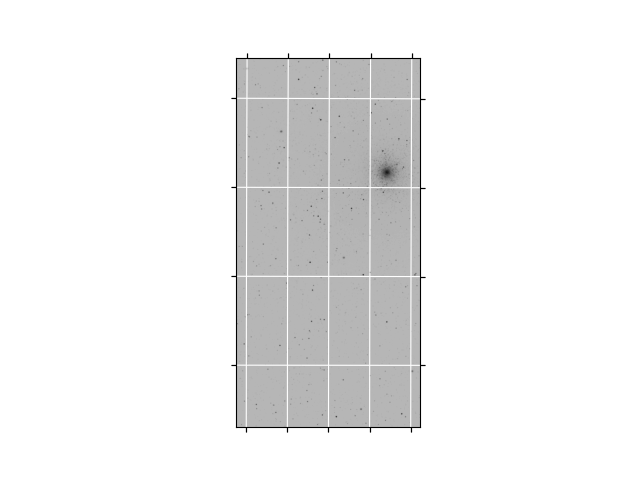

In [8]:
# Display full HDU image specified by target.
(fid,hduidx,ra,dec) = target

# Make sure archive file is valid.  Normally this will always be true, but we 
# are recovering from a "Mass Storage System" outage.
assert client.fitscheck(fid, verbose=True)['valid'], f"Invalid FITS file fid={fid}"

#'https://marsnat1-pat.csdc.noirlab.edu/api/retrieve/09a586a9d93a14a517f6d2e0e25f53da/?hdus=0,37'}
# Only get Primary and HDU containing our target.
fname = client.getimage(fid,hdus=[0,hduidx+1])
header0 = fits.getheader(fname, 0) # hdu0=Primary, hdu1=image
image_data1, header1 = fits.getdata(fname, 1, header=True) # hdu0=Primary, hdu1=image
print(f'HDU size in pixels = {image_data1.shape}')

%matplotlib widget
wcs = WCS(header1)
plt.subplot(projection=wcs)
plt.grid(color='white', ls='solid')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.imshow(image_data1, origin='lower', cmap='gray_r', norm='log')
plt.show()

In [9]:
help(client.cutout)

Help on method cutout in module astroget.experimental:

cutout(ra, dec, size, md5, hduidx, outfile=None, verbose=None) method of astroget.client.CsdcClient instance
    Generate and get a single cutout (FITS) from the Astro Data Archive.
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        ra (:obj:`float`): right ascension (decimal degrees) of center of target.
    
        dec (:obj:`float`): declination (decimal degrees) of center of target.
    
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        fid (:obj:`str`): File ID of FITS image in Astro Data Archive
    
        hduidx (:obj:`int`): Index of HDU in FITS file of Astro Data Archive
    
        outfile (str): Create subimage FITS file at this relative path location.
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cutouts for any targets that reference
            Prop

<a class="anchor" id="cutout_single"></a>
## Cutout and Display a single subimage

Get subimage centered at ra,dec=(283.763875, -30.479861) size 150. From image fid,hduidx=(09a586a9d93a14a517f6d2e0e25f53da, 36)
cutout url=http://localhost:8060/experimental/cutout/09a586a9d93a14a517f6d2e0e25f53da?ra=283.763875&dec=-30.479861&size=150&hduidx=37
subimage as been cutout into local FITS file: subimage_09a586a9d93a14a517f6d2e0e25f53da_283_-30.fits


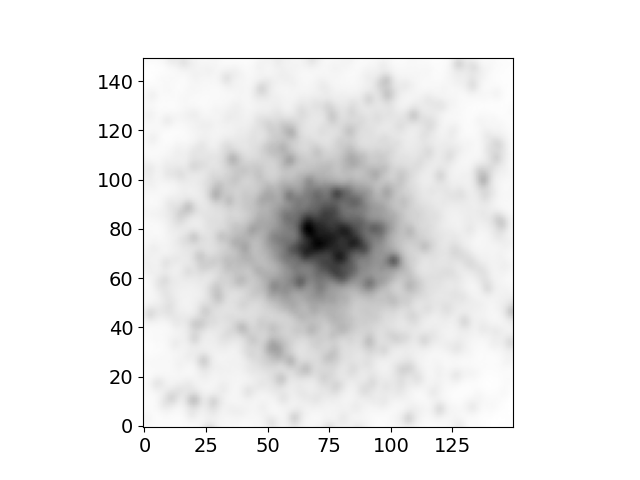

In [10]:
subimage_size = 150
print(f'Get subimage centered at ra,dec={(ra,dec)} size {subimage_size}. From image fid,hduidx=({fid}, {hduidx})')
# get FITS file
subimage = client.cutout(ra, dec, subimage_size, fid, hduidx, verbose=True)
print(f'subimage as been cutout into local FITS file: {subimage}')

image_data = fits.getdata(subimage)
plt.figure()
plt.imshow(image_data, origin='lower', cmap='gray_r')

<a class="anchor" id="batch_blocking"></a>
# Get a BATCH of cutouts (blocking)

In [11]:
print(f'Using Client context: \n{client.info}')

Using Client context: 
{'astroget_vers': '0.0.4a8', 'api_vers': 7.0, 'url': 'http://localhost:8060', 'verbose': False, 'show_curl': False, 'connect_timeout': 3.05, 'read_timeout': 600.0}


<a class="anchor" id="discoverBatch"></a>
## Set Targets for several cutouts 
Each Target consists of a tuple containing: 
- ImageId
- HDU
- RA
- DEC

In [12]:
help(client.cutouts)

Help on method cutouts in module astroget.experimental:

cutouts(size, target_list, tarfile='cutouts.tar', public_only=True, background=False, verbose=None) method of astroget.client.CsdcClient instance
    Retrieve a batch of cutout images from the Astro Data Archive.
    (Blocking)
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        target_list (:obj:`list`): List of 'targets'. Each 'target' consists
            of a tuple containing: fileId, hduIdx, RA_center, DEC_center
    
        tarfile (str): Create tarfile at this relative path location.
            The tarfile will contain each cutout image as a FITS file and
            MANIFEST.org file listed the files and where they came from.
            Default: 'cutouts.tar'
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cutouts fo

## Download cutouts into tarfile

In [13]:
targets[:10]

[['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
 ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
 ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
 ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
 ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 36, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 43, 283.763875, -30.479861],
 ['b5cb08bbcf5c03e036b4f08f115e5773', 34, 283.763875, -30.479861],
 ['bb72cb6b898159456030c268a2b04028', 34, 283.763875, -30.479861],
 ['bc1db7e4587c3966a2a73b12c33236b8', 34, 283.763875, -30.479861]]

In [14]:
tarfname0 = nbdir / 'nb-batch-0.tar.gz'
! rm {tarfname0} > /dev/null
client.cutouts(150, targets[:5], tarfile=tarfname0)

'OK'

In [15]:
runid = client.cutouts(51, targets[:10])
runid

'OK'

In [16]:
targets[:10]

[['09a586a9d93a14a517f6d2e0e25f53da', 36, 283.763875, -30.479861],
 ['2836105d9c941692f185a7e9ee902eab', 34, 283.763875, -30.479861],
 ['2d13e23d0cf2762890edaf9a179c3a1d', 36, 283.763875, -30.479861],
 ['3c8421ce38bf2a9112e3fbbb18405c33', 34, 283.763875, -30.479861],
 ['523c69cef368eaf24a66ac4010792490', 34, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 36, 283.763875, -30.479861],
 ['a5fb3eef401a24461e4cd4c25e773d8f', 43, 283.763875, -30.479861],
 ['b5cb08bbcf5c03e036b4f08f115e5773', 34, 283.763875, -30.479861],
 ['bb72cb6b898159456030c268a2b04028', 34, 283.763875, -30.479861],
 ['bc1db7e4587c3966a2a73b12c33236b8', 34, 283.763875, -30.479861]]

In [17]:
# Look at the contents of the tarfile
# Some cutouts may not exist if there was an error in extracting them. 
with tarfile.open(tarfname0) as tf:
    tf.list(verbose=False)

MANIFEST.csv 
cutout_0.fits 
cutout_1.fits 
cutout_2.fits 
cutout_3.fits 
cutout_4.fits 


In [18]:
# Extract the MANIFEST and two cutout (FITS file)
with tarfile.open(tarfname0) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
    tf.extract('cutout_1.fits', path=nbdir)
    tf.extract('cutout_3.fits', path=nbdir)


## Look at the MANIFEST
This SHOULD show a row for every target. If there as an error extract a particular target, it should say so on the Error column and the fits file will be present.  <This feature is broken 11/15/2023>

In [19]:
pd.read_csv(nbdir / 'MANIFEST.csv')  

Cutout  Size ArchiveName                            FileId  HDU  \
0  cutout_0.fits   150  m54-1.fits  09a586a9d93a14a517f6d2e0e25f53da   37   
1  cutout_1.fits   150  m54-2.fits  2836105d9c941692f185a7e9ee902eab   35   
2  cutout_2.fits   150  m54-3.fits  2d13e23d0cf2762890edaf9a179c3a1d   37   
3  cutout_3.fits   150  m54-4.fits  3c8421ce38bf2a9112e3fbbb18405c33   35   
4  cutout_4.fits   150  m54-5.fits  523c69cef368eaf24a66ac4010792490   35   

           RA        DEC    Ok  
0  283.763875 -30.479861  True  
1  283.763875 -30.479861  True  
2  283.763875 -30.479861  True  
3  283.763875 -30.479861  True  
4  283.763875 -30.479861  True

## Look at a couple of cutouts

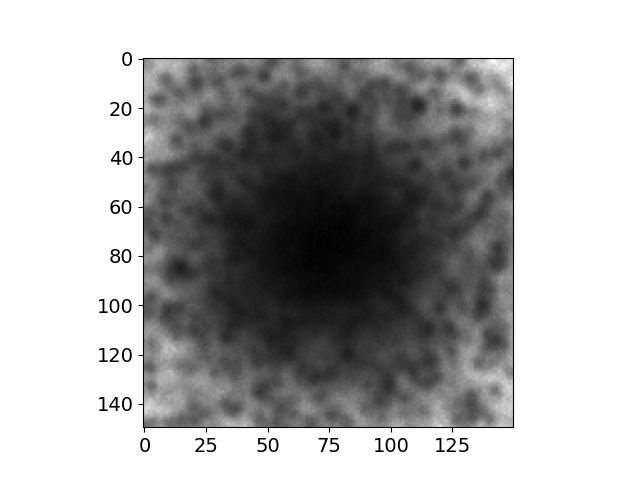

In [20]:
image_data = fits.getdata(nbdir / 'cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

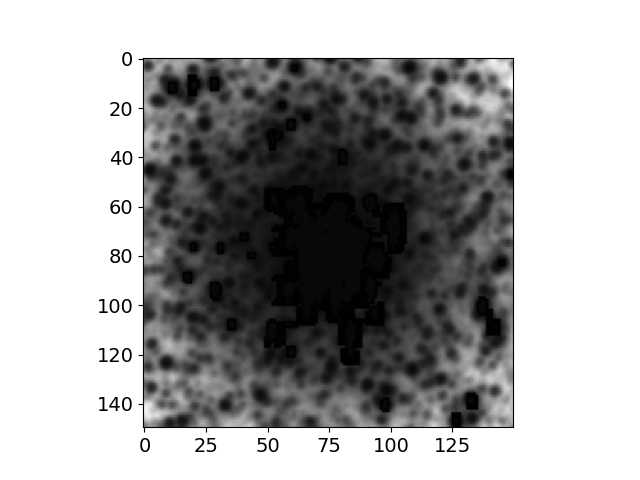

In [21]:
image_data = fits.getdata(nbdir / 'cutout_3.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

<a class="anchor" id="batch_non_blocking"></a>
# Get a BATCH of cutouts (non-blocking)
This is intended for a large batch cutouts that might take hours or days to complete. (but we will use a small batch here to keep demo time short) Since it might take a long time, we don't want our program to wait for the results. Instead, we fire off a job and will come back later to see if its done.

In [22]:
print(f'Using Client context: \n{client.info}')
tarfname1 = nbdir / 'nb-batch-1.tar.gz'
! rm {tarfname1}

Using Client context: 
{'astroget_vers': '0.0.4a8', 'api_vers': 7.0, 'url': 'http://localhost:8060', 'verbose': False, 'show_curl': False, 'connect_timeout': 3.05, 'read_timeout': 600.0}


In [23]:
help(client.bgcutouts)

Help on method bgcutouts in module astroget.experimental:

bgcutouts(size: int, target_list: list, tarfile: str = 'cutouts.tar.gz', public_only: bool = True, verbose: bool = None) method of astroget.client.CsdcClient instance
    Retrieve a batch of cutout images from the Astro Data Archive.
    
    This is an UNSUPPORTED and EXPERIMENTAL feature.
    It may be removed without notice!
    
    Args:
        size (:obj:`int`): Width and Height of desired cutout images (in pixels)
    
        target_list (:obj:`list`): List of 'targets'. Each 'target' consists
            of a tuple containing: fileId, hduIdx, RA_center, DEC_center
    
        tarfile (str): Create tarfile at this relative path location.
            The tarfile will contain each cutout image as a FITS file and
            MANIFEST.org file listed the files and where they came from.
            Default: 'cutouts.tar'
    
        public_only (:obj:`bool`, optional): If True (the default),
            do not generate cu

## Start batch run

In [24]:
print(f'Run batch of {len(targets)} targets')
runid = client.bgcutouts(150, targets[:250])
print(runid)
tic()

Run batch of 10 targets
d4f71dad-59f1-4dca-9235-8e2821ea76d9


## How is Run doing?
They __should be multiple threads showing below__.  Works on DEV but not PAT. 1/16/2024

E.G.
Active threads: {'MainThread': {'daemon': False, 'native_id': 4312}, 'django-main-thread': {'daemon': True, 'native_id': 4313}, 'Batch-Pool': {'daemon': True, 'native_id': 4886}, 'Thread-123 (process_request_thread)': {'daemon': True, 'native_id': 4887}, 'FB_0': {'daemon': True, 'native_id': 4889}, 'FB_1': {'daemon': True, 'native_id': 4890}, 'FB_2': {'daemon': True, 'native_id': 4891}, 'FB_3': {'daemon': True, 'native_id': 4892}, 'FB_4': {'daemon': True, 'native_id': 4893}, 'FB_5': {'daemon': True, 'native_id': 4894}, 'FB_6': {'daemon': True, 'native_id': 4895}, 'FB_7': {'daemon': True, 'native_id': 4896}}

In [25]:
#help(client.cutouts_status)
print(f'Threads: {pf(client.cutouts_threads(runid))}')
print(f'Status: {client.cutouts_status(runid)}')
print(f'Predictions: {pf(client.cutouts_predict(runid))}')
#!assert len(client.cutouts_threads(runid)) > 3
print(toc())

Threads: {'Batch-Pool': {'daemon': True, 'native_id': 41502},
 'FB_0': {'daemon': True, 'native_id': 41503},
 'FB_1': {'daemon': True, 'native_id': 41504},
 'FB_2': {'daemon': True, 'native_id': 41505},
 'FB_3': {'daemon': True, 'native_id': 41506},
 'FB_4': {'daemon': True, 'native_id': 41507},
 'FB_5': {'daemon': True, 'native_id': 41508},
 'FB_6': {'daemon': True, 'native_id': 41509},
 'FB_7': {'daemon': True, 'native_id': 41510},
 'MainThread': {'daemon': False, 'native_id': 38593},
 'Thread-92 (process_request_thread)': {'daemon': True, 'native_id': 41511},
 'django-main-thread': {'daemon': True, 'native_id': 38594}}
Status: PROCESSING
Predictions: {'est': {'done_time': 0.302579,
         'est_finish': '2982-12-20T17:22:24.453',
         'est_remain_time': 30257899999.69742,
         'est_total_file_size': 24700000000000.0,
         'est_total_time': 30257899999.999996,
         'file_size_done': 247,
         'now': '2024-02-19 13:09:04.756209',
         'num_tasks_done': 0,
    

In [26]:
client.cutouts_predict(runid)

{'remain_minutes': 525736667,
 'tarfile_mb': 24700001,
 'est': {'started': '2024-02-19 13:09:04.453630',
  'now': '2024-02-19 13:09:04.769072',
  'done_time': 0.315442,
  'num_tasks_total': 10,
  'num_tasks_done': 0,
  'file_size_done': 247,
  'est_total_time': 31544200000.0,
  'est_remain_time': 31544199999.68456,
  'est_total_file_size': 24700000000000.0,
  'est_finish': '3023-09-25T10:55:44.453'}}

## Wait for job to finish

In [27]:
client.cutouts_wait(runid, verbose=False, interval=1, max_minutes=15)


Started 2024-02-19 13:09:04.779944.
Report every 1 minutes.
Waiting no longer than 02/19/2024 13:24 UTC



Status: COMPLETED; Total wait: 0
Finished: 02/19/2024 13:09
Rate: 0 cutouts/min.


In [28]:
Audio('electric-piano-3.wav', autoplay=True)

In [29]:
print(toc())

3.291394741041586


In [30]:
client.cutouts_status(runid)

'COMPLETED'

In [31]:
print(client.cutouts_predict(runid))
print(client.cutouts_status(runid))

{'remain_minutes': 1, 'tarfile_mb': 2, 'est': {'started': '2024-02-19 13:09:04.453630', 'now': '2024-02-19 13:09:07.843649', 'done_time': 3.390019, 'num_tasks_total': 10, 'num_tasks_done': 10, 'file_size_done': 1458714, 'est_total_time': 3.3900189999661, 'est_remain_time': 0, 'est_total_file_size': 1458713.999985413, 'est_finish': '2024-02-19T13:09:07.843'}}
COMPLETED


## Get a tarfile containing the results

In [32]:
runid

'd4f71dad-59f1-4dca-9235-8e2821ea76d9'

In [33]:
client.cutouts_status(runid)

'COMPLETED'

In [34]:
client.cutouts_threads(runid)

{'MainThread': {'daemon': False, 'native_id': 38593},
 'django-main-thread': {'daemon': True, 'native_id': 38594},
 'Thread-103 (process_request_thread)': {'daemon': True, 'native_id': 41533}}

In [35]:
#client.show_curl=True
client.cutouts_get(runid, tarfile=tarfname1)

('OK', PosixPath('notebook-outfiles/nb-batch-1.tar.gz'))

In [36]:
# Extract the MANIFEST
with tarfile.open(tarfname1) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
    tf.extract('cutout_1.fits', path=nbdir)
df = pd.read_csv(nbdir / 'MANIFEST.csv')  
df

Cutout  Size ArchiveName                            FileId  HDU  \
0  cutout_0.fits   150  m54-1.fits  09a586a9d93a14a517f6d2e0e25f53da   37   
1  cutout_1.fits   150  m54-2.fits  2836105d9c941692f185a7e9ee902eab   35   
2  cutout_2.fits   150  m54-3.fits  2d13e23d0cf2762890edaf9a179c3a1d   37   
3  cutout_3.fits   150  m54-4.fits  3c8421ce38bf2a9112e3fbbb18405c33   35   
4  cutout_4.fits   150  m54-5.fits  523c69cef368eaf24a66ac4010792490   35   
5  cutout_5.fits   150  m54-6.fits  a5fb3eef401a24461e4cd4c25e773d8f   37   
6  cutout_6.fits   150  m54-6.fits  a5fb3eef401a24461e4cd4c25e773d8f   44   
7  cutout_7.fits   150  m54-7.fits  b5cb08bbcf5c03e036b4f08f115e5773   35   
8  cutout_8.fits   150  m54-8.fits  bb72cb6b898159456030c268a2b04028   35   
9  cutout_9.fits   150  m54-9.fits  bc1db7e4587c3966a2a73b12c33236b8   35   

           RA        DEC     Ok  
0  283.763875 -30.479861   True  
1  283.763875 -30.479861   True  
2  283.763875 -30.479861   True  
3  283.763875 -30.479861   True  
4  283.763875 -30.479861   True  
5  283.763875 -30.479861   True  
6  283.763875 -30.479861  False  
7  283.763875 -30.479861   True  
8  283.763875 -30.479861   True  
9  283.763875 -30.479861   True

In [37]:
print(f'Percent failed cutouts: {round(100*df.Ok.value_counts()[False]/df.shape[0])}%')

Percent failed cutouts: 10%


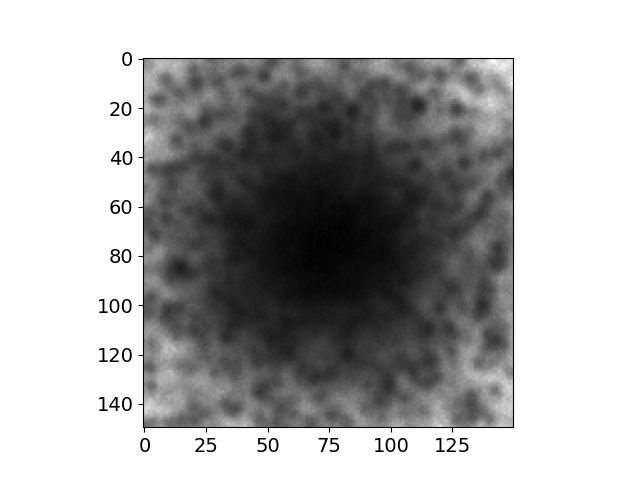

In [38]:
image_data = fits.getdata(nbdir / 'cutout_1.fits', ext=0)
plt.figure()
plt.imshow(image_data, cmap='gray')

# All Done

In [39]:
display(Markdown('# Code past here has not been run!'))

# Code past here has not been run!

In [40]:
print(f'Finished: {datetime.now()}')
print("Stopping execution to avoid long running functions. "
      " Continue manually if you want."
      " Typically via jupyter notebook menu: 'Run/Run Selected Cell and All Below'")
raise StopExecution

Finished: 2024-02-19 06:09:08.022457
Stopping execution to avoid long running functions.  Continue manually if you want. Typically via jupyter notebook menu: 'Run/Run Selected Cell and All Below'


# Random targets (using FIND)
This is just to get a large number of targets so we have a bigger batch job.

In [41]:
# HACK: filter HDUs on UPDATED time.  Bug NAT-762 prevents doing this the easy way.
# This gets around that bug.
constraints={"archive_filename": [".fits", "contains"], # DEV has some JSON files used for ingest
             "instrument": ["decam", "mosaic3", "bok23m"],
            }
if 'marsnat1' in server:
    constraints["updated"] = ["2024-01-10","2024-01-12"]
print(f'Using search FILE constraints: \n{pf(constraints)}')

# Find all the files recently added to support cu
found_recent = client.find(
    outfields=["md5sum", "updated"],
    constraints=constraints,
    filerec=True, # get FILE records (not HDU records)
    limit=None,   # get all matching records
    count=False)
print(f'Found {found_recent.count:,} recent images (FILE records)')
recent_fids = set([r.get('md5sum') for r in found_recent.records])

# find all HDUs (there many many more than there are files!) that have RA and DEC
const2 = {"hdu:ra_center":[-900, +900],  # not NULL
          "hdu:dec_center":[-900, +900]  # not NULL
         }
print(f'Using search HDU constraints: \n{pf(const2)}')

found2 = client.find(
    outfields=["md5sum", "hdu:hdu_idx", "hdu:ra_center", "hdu:dec_center"],
    constraints=const2,
    filerec=False,  # find HDU records
    limit=None,
    count=False)
print(f'Found {found2.count:,} HDU records')
#hdu_fids = set([rec['md5sum'] for rec in found2.records])
#target_fids = recent_fids & hdu_fids

tfields = ['md5sum','hdu:hdu_idx','hdu:ra_center','hdu:dec_center']
hdus2 = ([rec[k] for k in tfields] for rec in found2.records 
         if rec['md5sum'] in recent_fids)
targets2 = [[fid, hdu, ra, dec] for (fid,hdu,ra,dec) in hdus2]
print(f'Gathered {len(targets2):,} targets')

Using search FILE constraints: 
{'archive_filename': ['.fits', 'contains'],
 'instrument': ['decam', 'mosaic3', 'bok23m']}
Found 45 recent images (FILE records)
Using search HDU constraints: 
{'hdu:dec_center': [-900, 900], 'hdu:ra_center': [-900, 900]}
Found 1,297 HDU records
Gathered 1,293 targets


In [42]:
found2.records[0].keys()

dict_keys(['md5sum', 'hdu:hdu_idx', 'hdu:ra_center', 'hdu:dec_center', 'file:md5sum'])

In [43]:
pd.DataFrame(targets2, columns=['FID', 'HDU', 'RA', 'DEC'])

FID  HDU         RA        DEC
0     1c1077388a01afe822b9ed0716045091    2  323.36710   0.164324
1     1c1077388a01afe822b9ed0716045091    3  323.67780   0.164044
2     1c1077388a01afe822b9ed0716045091    5  323.21165   0.001088
3     1c1077388a01afe822b9ed0716045091    6  323.52240   0.000551
4     1c1077388a01afe822b9ed0716045091    8  322.74570  -0.162980
...                                ...  ...        ...        ...
1288  366712f24920b9efbe77a7105c0ebfb7   56  166.38320 -23.549210
1289  366712f24920b9efbe77a7105c0ebfb7   57  166.72240 -23.549550
1290  366712f24920b9efbe77a7105c0ebfb7   58  167.06100 -23.548710
1291  366712f24920b9efbe77a7105c0ebfb7   59  166.21360 -23.712650
1292  366712f24920b9efbe77a7105c0ebfb7   60  166.89200 -23.713270

[1293 rows x 4 columns]

In [69]:
tarfname2 = nbdir / 'nb-batch-2.tar.gz'
! rm {tarfname2} > /dev/null
# Random sample instead of first K to avoid clusters with similar problems.
tgt_subset = random.sample(targets2, k=min(len(targets2),4000))
print(f'Making {len(tgt_subset)} cutouts.')

Making 1293 cutouts.


In [70]:
runid = client.bgcutouts(51, tgt_subset)
print(f'Started job with {runid=}, {len(tgt_subset)} targets')

Started job with runid='446e9071-083b-4188-b098-477af29e7804', 1293 targets


In [75]:
%%time
tic()
runid = client.fgcutouts(51, tgt_subset, verbose=True)
elapsed = toc()
print(f'Finished {len(tgt_subset)} in {elapsed} secs. {int(60*len(tgt_subset)/elapsed)} cut/min')
runid

bgcutouts url=http://localhost:8060/experimental/fgcutouts/run?size=51
xgcutouts: res.content=b'9e07b93a-7ec1-46ab-a3d3-4d4e01b4b9a2'
Finished 1293 in 144.05541305895895 secs. 538.5427617929781 cut/min
CPU times: user 8.43 ms, sys: 1.73 ms, total: 10.2 ms
Wall time: 2min 24s


'9e07b93a-7ec1-46ab-a3d3-4d4e01b4b9a2'

## Wait

In [76]:
print(f'Status of {runid}: {client.cutouts_status(runid)}')

Status of 9e07b93a-7ec1-46ab-a3d3-4d4e01b4b9a2: COMPLETED


In [73]:
client.cutouts_wait(runid, verbose=False, interval=2, max_minutes=60)
Audio('electric-piano-3.wav', autoplay=True)


Started 2024-02-19 13:29:53.796643.
Report every 2 minutes.
Waiting no longer than 02/19/2024 14:29 UTC



Status: COMPLETED; Total wait: 0
Finished: 02/19/2024 13:29
Rate: 0 cutouts/min.


In [49]:
print(f'Status of {runid}: {client.cutouts_status(runid)}')

Status of 32981159-7f7b-4cc7-942a-1121e286baab: COMPLETED


In [50]:
client.cutouts_predict(runid)

{'remain_minutes': 1,
 'tarfile_mb': 5,
 'est': {'started': '2024-02-19 13:09:32.529843',
  'now': '2024-02-19 13:11:03.439327',
  'done_time': 90.909484,
  'num_tasks_total': 400,
  'num_tasks_done': 400,
  'file_size_done': 4527326,
  'est_total_time': 90.90948399997728,
  'est_remain_time': 0,
  'est_total_file_size': 4527325.999998868,
  'est_finish': '2024-02-19T13:11:03.439'}}

In [51]:
client.cutouts_get(runid, tarfile=tarfname2)

('OK', PosixPath('notebook-outfiles/nb-batch-2.tar.gz'))

In [52]:
with tarfile.open(tarfname2) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
df = pd.read_csv(nbdir / 'MANIFEST.csv')  
df

Cutout  Size                           ArchiveName  \
0      cutout_0.fits    51                            m54-4.fits   
1      cutout_1.fits    51    c4d_190816_015914_oki_i_v1.fits.fz   
2      cutout_2.fits    51  c4d_170806_042940_opw_r_v1.fits.json   
3      cutout_3.fits    51  c4d_170806_045035_opd_g_v1.fits.json   
4      cutout_4.fits    51                            m54-9.fits   
..               ...   ...                                   ...   
395  cutout_395.fits    51    c4d_180418_040746_ood_g_v1.fits.fz   
396  cutout_396.fits    51  c4d_170806_045035_opd_g_v1.fits.json   
397  cutout_397.fits    51  c4d_170806_043306_oki_Y_v1.fits.json   
398  cutout_398.fits    51    c4d_190622_004628_opi_g_v1.fits.fz   
399  cutout_399.fits    51  c4d_170806_042940_oki_r_v1.fits.json   

                               FileId  HDU         RA        DEC     Ok  
0    3c8421ce38bf2a9112e3fbbb18405c33   12  284.48005 -29.826570   True  
1    d35a16fe507abaa73806f2bcb88c86b4   14  315.87840 -65.582900  False  
2    a18cb4d0d1a8ed983f933920b3c3d326   41  322.89830  -0.984958  False  
3    cb8647f6a45cb86a0971bfa066c58a18    2  322.17945  13.154795  False  
4    bc1db7e4587c3966a2a73b12c33236b8   31  284.84000 -30.315800   True  
..                                ...  ...        ...        ...    ...  
395  666aed6bdbe185a0f47d9e52645bc239   21  202.69820  -9.786658  False  
396  cb8647f6a45cb86a0971bfa066c58a18   55  322.81310  11.673520  False  
397  1c1077388a01afe822b9ed0716045091   53  323.05385  -1.314847  False  
398  366712f24920b9efbe77a7105c0ebfb7   12  167.22530 -22.233200  False  
399  37231e2982c74c9d422715f3faaa5610   19  324.14285  -0.328800  False  

[400 rows x 8 columns]

In [53]:
print(f'Percent failed cutouts: {round(100*df.Ok.value_counts()[False]/df.shape[0])}%')

Percent failed cutouts: 58%


In [54]:
runid

'32981159-7f7b-4cc7-942a-1121e286baab'

In [55]:
good_fids = list(df.loc[df["Ok"], ["FileId"]]['FileId'])
print(f'good_fids({len(good_fids)}) = {good_fids}')

good_fids(166) = ['3c8421ce38bf2a9112e3fbbb18405c33', 'bc1db7e4587c3966a2a73b12c33236b8', '2836105d9c941692f185a7e9ee902eab', '09a586a9d93a14a517f6d2e0e25f53da', 'bc1db7e4587c3966a2a73b12c33236b8', '523c69cef368eaf24a66ac4010792490', 'b5cb08bbcf5c03e036b4f08f115e5773', '3c8421ce38bf2a9112e3fbbb18405c33', '2836105d9c941692f185a7e9ee902eab', '523c69cef368eaf24a66ac4010792490', '3c8421ce38bf2a9112e3fbbb18405c33', 'b5cb08bbcf5c03e036b4f08f115e5773', 'a5fb3eef401a24461e4cd4c25e773d8f', '2d13e23d0cf2762890edaf9a179c3a1d', '2836105d9c941692f185a7e9ee902eab', '523c69cef368eaf24a66ac4010792490', 'b5cb08bbcf5c03e036b4f08f115e5773', '2d13e23d0cf2762890edaf9a179c3a1d', 'bb72cb6b898159456030c268a2b04028', 'a5fb3eef401a24461e4cd4c25e773d8f', '09a586a9d93a14a517f6d2e0e25f53da', '523c69cef368eaf24a66ac4010792490', 'a5fb3eef401a24461e4cd4c25e773d8f', '09a586a9d93a14a517f6d2e0e25f53da', 'b5cb08bbcf5c03e036b4f08f115e5773', '2836105d9c941692f185a7e9ee902eab', 'a5fb3eef401a24461e4cd4c25e773d8f', 'bb72cb6b8

In [56]:
len(good_fids)

166

# Good targets 
(using filtered previous results)

In [57]:
good_targets = [t for t in targets2 if t[0] in good_fids]
len(good_targets)

549

## Block til finished

In [58]:
tarfname3 = nbdir / 'nb-batch-3.tar.gz'

In [59]:
#runid = client.bgcutouts(51, good_targets)
size = 860 # 51, 225, 445, 860, 1600
tgts = random.sample(good_targets, k=min(len(good_targets),300))
print(f'Starting run to get {len(tgts)} targets is size={size} ...')
tic()
client.cutouts(size, tgts, tarfile=tarfname3) 
elapsed = toc()
print(f'... Got {round(len(tgts)/(elapsed/60))} cutouts/min.'
      f' {len(tgts)} cutouts of size {size}.')
print(f'Results stored in: {tarfname3}')

Starting run to get 300 targets is size=860 ...
... Got 147 cutouts/min. 300 cutouts of size 860.
Results stored in: notebook-outfiles/nb-batch-3.tar.gz


In [60]:
Audio('electric-piano-3.wav', autoplay=True)

In [61]:
with tarfile.open(tarfname3) as tf:
    tf.extract('MANIFEST.csv', path=nbdir)
df = pd.read_csv(nbdir / 'MANIFEST.csv')  
df

Cutout  Size ArchiveName                            FileId  HDU  \
0      cutout_0.fits   860  m54-8.fits  bb72cb6b898159456030c268a2b04028   35   
1      cutout_1.fits   860  m54-6.fits  a5fb3eef401a24461e4cd4c25e773d8f   34   
2      cutout_2.fits   860  m54-4.fits  3c8421ce38bf2a9112e3fbbb18405c33    2   
3      cutout_3.fits   860  m54-4.fits  3c8421ce38bf2a9112e3fbbb18405c33   36   
4      cutout_4.fits   860  m54-6.fits  a5fb3eef401a24461e4cd4c25e773d8f   55   
..               ...   ...         ...                               ...  ...   
295  cutout_295.fits   860  m54-8.fits  bb72cb6b898159456030c268a2b04028   10   
296  cutout_296.fits   860  m54-6.fits  a5fb3eef401a24461e4cd4c25e773d8f   50   
297  cutout_297.fits   860  m54-5.fits  523c69cef368eaf24a66ac4010792490   25   
298  cutout_298.fits   860  m54-4.fits  3c8421ce38bf2a9112e3fbbb18405c33   35   
299  cutout_299.fits   860  m54-3.fits  2d13e23d0cf2762890edaf9a179c3a1d   46   

            RA        DEC    Ok  
0    283.76130 -30.482255  True  
1    282.63925 -30.412290  True  
2    283.76485 -29.498015  True  
3    284.12215 -30.484910  True  
4    283.72205 -30.907675  True  
..         ...        ...   ...  
295  283.76400 -29.823710  True  
296  283.90240 -30.742715  True  
297  282.68260 -30.308985  True  
298  283.76110 -30.484260  True  
299  282.45395 -30.742565  True  

[300 rows x 8 columns]

In [62]:
fail_cnt = df.shape[0] - df.Ok.value_counts()[True]
print(f'Percent failed cutouts: {round(100*fail_cnt)}%')

Percent failed cutouts: 0%


# !jupyter --version